In [40]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import time
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle as pkl
import networkx as nx
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf

from pprint import pprint

import src
from src.reload import deep_reload

In [41]:
directory = 'Outputs/Random_Experiment/'

files = os.listdir(directory)

In [42]:
def adjusted_rta(values, vehicle_kw, keys = []):

    rta = src.routing.road_trip_accessibility(values)

    end_soc = src.routing.road_trip_accessibility(
        values, field = 'soc', keys = keys,
    )

    excess_chg_time = (end_soc - .1) * vehicle_kw['capacity'] / vehicle_kw['charge_rate']

    return (rta - excess_chg_time) / 3600

In [43]:
sng_tesla = src.graph.graph_from_json('Outputs/sng_tesla.json')

cities = [k for k, v in sng_tesla._node.items() if v['type'] == 'city']

In [63]:
deep_reload(src)

functions = {
    'capacity': lambda x: x[1]['capacity'] / 3.6e6,
    'charge_rate': lambda x: x[1]['charge_rate'] / 1e3,
    'risk_attitude_low': lambda x: x[1]['risk_attitude'][0],
    'risk_attitude_high': lambda x: x[1]['risk_attitude'][1],
    'reliability': lambda x: x[2]['reliability'],
    'graph_index': lambda x: x[0],
    'rta': lambda x: src.routing.road_trip_accessibility(x[4], keys = cities) / 3600,
    'rta_adj': lambda x: adjusted_rta(x[4], out[1], keys = cities),
}

outputs = {k: [] for k in functions.keys()}

idx = 0

for file in src.progress_bar.ProgressBar(files):

    idx += 1

    if idx < 30:

        continue

    with open(directory + file, 'rb') as f:

        out = pkl.load(f)

    for key, fun in functions.items():

        outputs[key].append(fun(out))

 [------->] (1530/1530) 100.00%, 190.28 it/s, 8.05 s elapsed, 0.00 s remaining

In [64]:
outputs_norm = outputs.copy()

keys = ['capacity', 'charge_rate', 'risk_attitude_low', 'reliability']

for key in keys:

    value = outputs[key]

    outputs_norm[key] = (np.array(value) - min(value)) / (max(value) - min(value))

df = pd.DataFrame(data = outputs_norm)

In [65]:
df

,capacity,charge_rate,risk_attitude_low,risk_attitude_high,reliability,graph_index,rta,rta_adj
0,0.628325,0.150059,0.009384,0.209677,0.982433,1,5.835745,5.513250
1,0.520388,0.676750,0.773983,0.818521,0.040679,1,5.670871,5.538953
2,0.005379,0.734405,0.161712,0.330975,0.374588,1,5.958429,5.910426
3,0.153125,0.472601,0.436234,0.549575,0.079289,1,5.962852,5.873826
4,0.050993,0.418436,0.929396,0.942276,0.298562,2,6.238032,6.145737
...,...,...,...,...,...,...,...,...
1496,0.360140,0.200807,0.451453,0.561693,0.646606,0,5.946522,5.760149
1497,0.975404,0.106890,0.055967,0.246771,0.471534,2,5.708525,5.129374
1498,0.968090,0.260906,0.947230,0.956477,0.415512,2,5.652050,5.219570
1499,0.171095,0.918602,0.819942,0.855119,0.395639,0,5.750440,5.690586


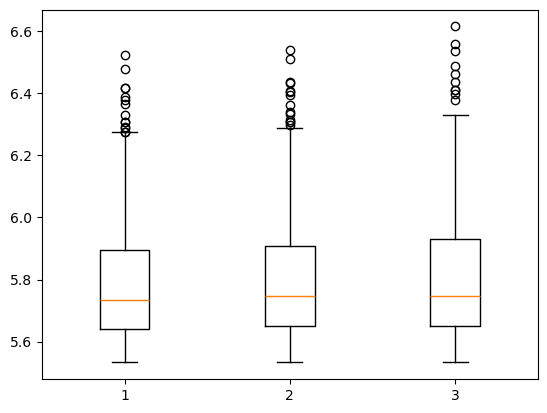

In [66]:
x = [
    df[df['graph_index'] == 0]['rta'],
    df[df['graph_index'] == 1]['rta'],
    df[df['graph_index'] == 2]['rta'],
]

_ = plt.boxplot(x)

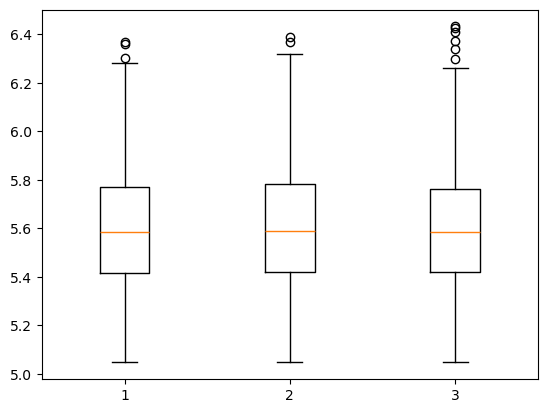

In [67]:
x = [
    df[df['graph_index'] == 0]['rta_adj'],
    df[df['graph_index'] == 1]['rta_adj'],
    df[df['graph_index'] == 2]['rta_adj'],
]

_ = plt.boxplot(x)

In [68]:
# df_sel = df[(df['graph_index'] == 0)]
df_sel = df

formula = (
    'rta ~ ' +
    'C(graph_index) * ' + 
    'capacity * ' + 
    'charge_rate * ' + 
    'reliability * ' +
    # 'risk_attitude_low * ' +
    'risk_attitude_low'
)

# formula = (
#     'rta ~ ' +
#     'C(graph_index) + ' + 
#     'capacity + ' + 
#     'charge_rate + ' + 
#     'reliability + ' +
#     # 'risk_attitude_low + ' +
#     'risk_attitude_high'
# )

model = smf.ols(formula, data = df_sel).fit()

In [69]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    rta   R-squared:                       0.908
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                     306.8
Date:                Tue, 21 May 2024   Prob (F-statistic):               0.00
Time:                        18:36:04   Log-Likelihood:                 2085.2
No. Observations:                1501   AIC:                            -4074.
Df Residuals:                    1453   BIC:                            -3819.
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
==========================================================================================================================================
                                                                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                  6.2897      0.046    136.707      0.000       6.199       6.380
C(graph_index)[T.1]                                                        0.0199      0.065      0.304      0.761      -0.108       0.148
C(graph_index)[T.2]                                                        0.0259      0.065      0.398      0.691      -0.102       0.154
capacity                                                                  -0.6392      0.080     -7.961      0.000      -0.797      -0.482
C(graph_index)[T.1]:capacity                                              -0.0149      0.113     -0.132      0.895      -0.236       0.206
C(graph_index)[T.2]:capacity                                              -0.0133      0.112     -0.118      0.906      -0.234       0.207
charge_rate                                                               -0.6136      0.080     -7.710      0.000      -0.770      -0.457
C(graph_index)[T.1]:charge_rate                                            0.0012      0.113      0.010      0.992      -0.220       0.223
C(graph_index)[T.2]:charge_rate                                           -0.1036      0.113     -0.919      0.358      -0.325       0.117
capacity:charge_rate                                                       0.4214      0.138      3.059      0.002       0.151       0.692
C(graph_index)[T.1]:capacity:charge_rate                                  -0.0100      0.194     -0.051      0.959      -0.391       0.371
C(graph_index)[T.2]:capacity:charge_rate                                   0.0850      0.194      0.439      0.661      -0.295       0.465
reliability                                                                0.0992      0.079      1.251      0.211      -0.056       0.255
C(graph_index)[T.1]:reliability                                            0.0072      0.112      0.064      0.949      -0.213       0.228
C(graph_index)[T.2]:reliability                                           -0.0320      0.112     -0.285      0.776      -0.253       0.189
capacity:reliability                                                      -0.1315      0.137     -0.961      0.337      -0.400       0.137
C(graph_index)[T.1]:capacity:reliability                                  -0.0097      0.193     -0.050      0.960      -0.388       0.369
C(graph_index)[T.2]:capacity:reliability                                   0.0400      0.193      0.207      0.836      -0.339       0.419
charge_rate:reliability                                                   -0.1179      0.137     -0.858      0.391      -0.387       0.152
C(graph_index)[T.1]:charg

In [70]:
deep_reload(src)

label_substitutions={
    'C(graph_index)[T.1]': 'Tesla Only',
    'C(graph_index)[T.2]': 'Non-Tesla Only',
    'risk_attitude_low': 'risk_attitude',
}

out_string=src.analysis.significant_parameters_tabular(
    model, alpha = .05,
    label_substitutions = label_substitutions
)

print(out_string)

\hline {\small Intercept } & 6.290 & 0.000 \\
\hline {\small capacity } & -0.639 & 0.000 \\
\hline {\small charge_rate } & -0.614 & 0.000 \\
\hline {\small risk_attitude } & 0.199 & 0.011 \\
\hline {\small capacity:charge_rate } & 0.421 & 0.002 \\
\hline {\small reliability:risk_attitude } & -0.368 & 0.008 \\
\hline {\small charge_rate:reliability:risk_attitude } & 0.507 & 0.028 \\



In [71]:
deep_reload(src)

label_substitutions={
    'C(graph_index)[T.1]': 'Tesla Only',
    'C(graph_index)[T.2]': 'Non-Tesla Only',
    'risk_attitude_low': 'risk_attitude',
}

out_string=src.analysis.model_anova_tabular(
    model, df, 'rta', 4, c = 3,
)

print(out_string)

4 48
1453 47 1500
\hline R & R-Squared & Adjusted R-Squared & Std. Error \\
\hline 0.953 & 0.908 & 0.905 & 0.000 \\
\hline
\hline Category & Sum of Squares & DOF & Mean Squares \\
\hline Model & 54.186 & 47 & 1.153 \\
\hline Error & 5.461 & 1453 & 0.004 \\
\hline Total & 59.647 & 1500 & 0.040 \\
\hline  \multicolumn{2}{|c|}{$F$} &  \multicolumn{2}{c|}{$P(>F)$}  \\
\hline  \multicolumn{2}{|c|}{306.764} &  \multicolumn{2}{c|}{0.000}  \\
\hline
None


In [117]:
from math import comb

n = df_sel.shape[0]
m = 5

n, sum([comb(m, n) for n in range(m + 1)])

(935, 32)

In [118]:
comb(m, 4)

5

In [32]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    rta   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Mon, 20 May 2024   Prob (F-statistic):                nan
Time:                        23:46:49   Log-Likelihood:                 306.91
No. Observations:                  10   AIC:                            -593.8
Df Residuals:                       0   BIC:                            -590.8
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
======================================================================================================================
                                                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------
Intercept                                              6.0297        inf          0        nan         nan         nan
capacity                                               0.0788        inf          0        nan         nan         nan
charge_rate                                           -0.1931        inf         -0        nan         nan         nan
capacity:charge_rate                                   0.1876        inf          0        nan         nan         nan
reliability                                            0.4739        inf          0        nan         nan         nan
capacity:reliability                                  -0.7126        inf         -0        nan         nan         nan
charge_rate:reliability                               -0.7116        inf         -0        nan         nan         nan
capacity:charge_rate:reliability                       0.1689        inf          0        nan         nan         nan
risk_attitude_low                                      0.0461        inf          0        nan         nan         nan
capacity:risk_attitude_low                            -0.6198        inf         -0        nan         nan         nan
charge_rate:risk_attitude_low                         -0.0120        inf         -0        nan         nan         nan
capacity:charge_rate:risk_attitude_low                 0.0843        inf          0        nan         nan         nan
reliability:risk_attitude_low                          0.1758        inf          0        nan         nan         nan
capacity:reliability:risk_attitude_low                 0.0766        inf          0        nan         nan         nan
charge_rate:reliability:risk_attitude_low              0.0977        inf          0        nan         nan         nan
capacity:charge_rate:reliability:risk_attitude_low     0.2551        inf          0        nan         nan         nan
==============================================================================
Omnibus:                        1.257   Durbin-Watson:                   1.045
Prob(Omnibus):                  0.534   Jarque-Bera (JB):                0.680
Skew:                          -0.601   Prob(JB):                        0.712
Kurtosis:                       2.571   Cond. No.                         69.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The input rank is higher than the number of observations.
"""

In [97]:
fun = lambda rng: (rng.random() * .8 + .1) + np.array([-.1, .1])

rng = np.random.default_rng()

fun(rng)

array([0.22052842, 0.42052842])